In [1]:
import os
import re
import shutil
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, BatchNormalization, Activation,
    Conv2D, Input, GlobalAveragePooling2D,
    RandomFlip, RandomRotation
)
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model


2025-05-17 09:49:59.127159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747475399.593906      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747475399.718864      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Image preprocessing

## Cropping

In [2]:
"""base_input_dir = '/kaggle/input/dataset/MPI Images SELECTED/' 
output_dir = '/kaggle/working/cropped_images/'  

os.makedirs(output_dir, exist_ok=True)

# (left, upper, right, lower)
crop_box = (320, 0, 950, 930)  
crop_box1 = (10,80, 1026, 830)

excluded_pattern = ["Display"] 


for patient_folder in os.listdir(base_input_dir):
    patient_folder_path = os.path.join(base_input_dir, patient_folder)
    
    if os.path.isdir(patient_folder_path):
        output_patient_dir = os.path.join(output_dir, patient_folder)
        os.makedirs(output_patient_dir, exist_ok=True)
        
        for filename in os.listdir(patient_folder_path):
            if filename.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                img_path = os.path.join(patient_folder_path, filename)
                
                
                if any(pattern in filename for pattern in excluded_pattern):
                    img = Image.open(img_path)
                    cropped_img1 = img.crop(crop_box1) 
                    cropped_img1.save(os.path.join(output_patient_dir, f"cropped_{filename}")) 
                else:
                    
                    img = Image.open(img_path)
                    cropped_img = img.crop(crop_box)
                    cropped_img.save(os.path.join(output_patient_dir, f"cropped_{filename}")) 

print("done.")
import shutil

shutil.make_archive('/kaggle/working/cropped_images', 'zip', output_dir)"""

'base_input_dir = \'/kaggle/input/dataset/MPI Images SELECTED/\' \noutput_dir = \'/kaggle/working/cropped_images/\'  \n\nos.makedirs(output_dir, exist_ok=True)\n\n# (left, upper, right, lower)\ncrop_box = (320, 0, 950, 930)  \ncrop_box1 = (10,80, 1026, 830)\n\nexcluded_pattern = ["Display"] \n\n\nfor patient_folder in os.listdir(base_input_dir):\n    patient_folder_path = os.path.join(base_input_dir, patient_folder)\n    \n    if os.path.isdir(patient_folder_path):\n        output_patient_dir = os.path.join(output_dir, patient_folder)\n        os.makedirs(output_patient_dir, exist_ok=True)\n        \n        for filename in os.listdir(patient_folder_path):\n            if filename.lower().endswith((\'.bmp\', \'.png\', \'.jpg\', \'.jpeg\')):\n                img_path = os.path.join(patient_folder_path, filename)\n                \n                \n                if any(pattern in filename for pattern in excluded_pattern):\n                    img = Image.open(img_path)\n              

In [3]:
SEED = 4242
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Augmentation

In [4]:
'''
input_dir = '/kaggle/input/cropped-images/cropped_images2/' 
output_dir = '/kaggle/working/4flip/'


os.makedirs(output_dir, exist_ok=True)


target_image_parts = [
    'AC QPS (clear)',  
    'Rest QGS (clear)',
    'Stress QGS (clear)'
]


for patient_folder in os.listdir(input_dir):
    patient_folder_path = os.path.join(input_dir, patient_folder)

    if os.path.isdir(patient_folder_path):
        output_patient_dir = os.path.join(output_dir, patient_folder)
        os.makedirs(output_patient_dir, exist_ok=True)

        for filename in os.listdir(patient_folder_path):
            if filename.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                if any(target_part in filename for target_part in target_image_parts):
                    img_path = os.path.join(patient_folder_path, filename)
                    img = Image.open(img_path).convert('RGB')  #
                    base_name = os.path.splitext(filename)[0]

                    
                    img.save(os.path.join(output_patient_dir, f"{base_name}_west_original.jpg"))

                  
                    img_east = img.transpose(Image.FLIP_LEFT_RIGHT)
                    img_east.save(os.path.join(output_patient_dir, f"{base_name}_east_flip_horizontal.jpg"))

                   
                    img_north = img.transpose(Image.FLIP_TOP_BOTTOM)
                    img_north.save(os.path.join(output_patient_dir, f"{base_name}_north_flip_vertical.jpg"))

            
                    img_south = img_east.transpose(Image.FLIP_TOP_BOTTOM)
                    img_south.save(os.path.join(output_patient_dir, f"{base_name}_south_flip_both.jpg"))

print("Done")'''

'\ninput_dir = \'/kaggle/input/cropped-images/cropped_images2/\' \noutput_dir = \'/kaggle/working/4flip/\'\n\n\nos.makedirs(output_dir, exist_ok=True)\n\n\ntarget_image_parts = [\n    \'AC QPS (clear)\',  \n    \'Rest QGS (clear)\',\n    \'Stress QGS (clear)\'\n]\n\n\nfor patient_folder in os.listdir(input_dir):\n    patient_folder_path = os.path.join(input_dir, patient_folder)\n\n    if os.path.isdir(patient_folder_path):\n        output_patient_dir = os.path.join(output_dir, patient_folder)\n        os.makedirs(output_patient_dir, exist_ok=True)\n\n        for filename in os.listdir(patient_folder_path):\n            if filename.lower().endswith((\'.bmp\', \'.png\', \'.jpg\', \'.jpeg\')):\n                if any(target_part in filename for target_part in target_image_parts):\n                    img_path = os.path.join(patient_folder_path, filename)\n                    img = Image.open(img_path).convert(\'RGB\')  #\n                    base_name = os.path.splitext(filename)[0]\n\n  

## Normalization and Stacking

In [5]:
def pad_image(img, target_size=(224, 224)):
    width, height = img.size
    new_width, new_height = target_size

    if width > new_width or height > new_height:
        img.thumbnail((new_width, new_height), Image.LANCZOS)
        width, height = img.size 

    padding_width = (new_width - width) // 2
    padding_height = (new_height - height) // 2

    padded_img = np.pad(np.array(img),
                        ((padding_height, new_height - height - padding_height),
                         (padding_width, new_width - width - padding_width),
                         (0, 0)),
                        mode='constant', constant_values=0)
    return padded_img


In [6]:
final_dir = '/kaggle/input/flipped1'
variant_keys = ['west_original', 'east_flip_horizontal', 'north_flip_vertical', 'south_flip_both']
image_names_to_select = ['AC QPS (clear)', 'Rest QGS (clear)', 'Stress QGS (clear)']
target_labels = ['normal', 'ischemia', 'infarction'] 

X_img = []
y_img = []
for folder in os.listdir(final_dir):
    folder_path = os.path.join(final_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    label = next((lbl for lbl in target_labels if lbl in folder.lower()), None)
    if label is None:
        continue

    files = [f for f in os.listdir(folder_path) if f.startswith('cropped')]

    grouped = defaultdict(dict)

    for f in files:
        match = re.match(r'(cropped_\d+ )(.+?)_(.+?)\.jpg$', f)
        if match:
            _, view_name, variant_key = match.groups()
            if view_name in image_names_to_select and variant_key in variant_keys:
                grouped[variant_key][view_name] = f

    for variant_key in variant_keys:
        views = grouped.get(variant_key, {})
        patient_images = []

        for view in image_names_to_select:
            matched_file = views.get(view)
            if matched_file:
                img_path = os.path.join(folder_path, matched_file)

                img = Image.open(img_path).convert('RGB')
                padded_img = pad_image(img, target_size=(224, 224))  # Apply center padding to square
                img_arr = preprocess_input(np.array(padded_img))
            else:
                img_arr = preprocess_input(np.zeros((224, 224, 3), dtype=np.float32))

            patient_images.append(img_arr)

        # Stack 3 images per patient (9 channels)
        stacked = np.concatenate(patient_images, axis=-1)
        X_img.append(stacked)
        y_img.append(target_labels.index(label))

X_img = np.array(X_img)
y_img = to_categorical(np.array(y_img), num_classes=3)

print("X shape:", X_img.shape) 
print("y shape:", y_img.shape)

X shape: (388, 224, 224, 9)
y shape: (388, 3)


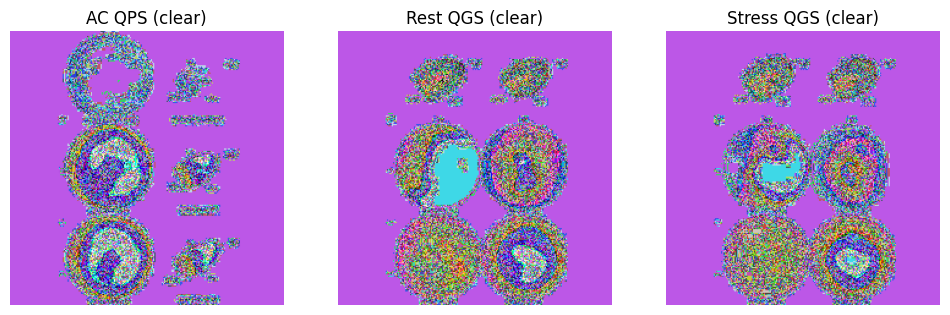

In [7]:
sample = X_img[110]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(((sample[:, :, i*3:(i+1)*3] + 1) * 127.5).astype(np.uint8))  # Undo preprocessing
    axs[i].set_title(image_names_to_select[i])
    axs[i].axis('off')
plt.show()


# Tabular Data

In [8]:
data = pd.read_csv('/kaggle/input/idkidk/data (2).csv')

data = pd.get_dummies(data,columns=['Sex'])

data = data.drop(['ID'],axis=1)

label_map = {
    'Normal': 0,
    'Ischemia': 1,
    'Infarction': 2
}

data['Label'] = data['Label'].map(label_map)

features = data.drop(['Label'],axis=1)
correlation = features.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] == 1)]
data = data.drop(columns=to_drop)

In [9]:
y_tabular = data['Label']
X_tabular = data.drop(['Label'],axis=1)

## split both imagery data and tabular data to training and testing

In [10]:
X_img = np.array(X_img)
X_tabular = np.array(X_tabular)

assert X_img.shape[0] == X_tabular.shape[0]
X_combined = list(zip(X_img, X_tabular))
y_labels = np.argmax(y_img, axis=1)

X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y_labels, test_size=0.2, random_state=42)

X_train_img, X_train_tabular = zip(*X_train_combined)
X_val_img, X_test_tabular = zip(*X_test_combined)

X_train_img = np.array(X_train_img)
X_train_tabular = np.array(X_train_tabular)

X_val_img = np.array(X_val_img)
X_test_tabular = np.array(X_test_tabular)

y_test_tabular, y_val_img = y_test, y_test
y_train_tabular , y_train_img = y_train, y_train

## ________________________________________________________________________________________________________________________________________________________________________________________________

In [11]:
scaler = MinMaxScaler()
X_train_tabular = scaler.fit_transform(X_train_tabular)
X_test_tabular = scaler.transform(X_test_tabular)

X_train_tabular = np.nan_to_num(X_train_tabular, nan=np.nanmean(X_train_tabular))
X_test_tabular = np.nan_to_num(X_test_tabular, nan=np.nanmean(X_test_tabular))

data_to_select_features = data.drop(columns=['Label'])
original_feature_names = data_to_select_features.columns

selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_tabular, y_train_tabular)
X_test_sel = selector.transform(X_test_tabular)

selected_features = original_feature_names[selector.get_support()]

X_train_tabular = X_train_sel
X_test_tabular = X_test_sel

y_train_label = y_train_tabular
y_train_tabular = to_categorical(y_train_tabular, num_classes=3)
y_test_tabular = to_categorical(y_test_tabular, num_classes=3)
y_train_img = to_categorical(y_train_img, num_classes=3)
y_val_img = to_categorical(y_val_img, num_classes=3)
input_shape = X_train_tabular.shape[1:]

# CNN Model

In [70]:
# Input (9 channels)
input_9ch = Input(shape=(224, 224, 9), name="input_9channel")

reduced = Conv2D(3, (1, 1), activation='relu', name="reduce_channels")(input_9ch)

resnet_base = ResNet50(include_top=False, 
                       weights='imagenet',
                       input_shape=(224, 224, 3))

resnet_base.trainable = False  

x = resnet_base(reduced)
x = GlobalAveragePooling2D()(x)

x = Dense(64, kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.7)(x)



output = Dense(3, activation='softmax', kernel_regularizer = l2(0.005))(x)

cnn_model = Model(inputs=input_9ch, outputs=output)
for layer in resnet_base.layers[-10:]:
   layer.trainable = True

optimizer = Adam(learning_rate=0.0002) 
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.005)

cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
cnn_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_9channel (InputLayer)          │ (None, 224, 224, 9)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reduce_channels (Conv2D)             │ (None, 224, 224, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_18          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,329 (90.48 MB)

 Trainable params: 4,597,153 (17.54 MB)

 Non-trainable params: 19,122,176 (72.95 MB)

In [71]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = cnn_model.fit(
    X_train_img, y_train_img,
    validation_data=(X_val_img, y_val_img),
    epochs=50,
    batch_size=32, 
    callbacks = [lr_scheduler]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5250 - loss: 1.8760 - val_accuracy: 0.6923 - val_loss: 1.6595 - learning_rate: 2.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.7131 - loss: 1.3819 - val_accuracy: 0.7051 - val_loss: 1.5219 - learning_rate: 2.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.7098 - loss: 1.3237 - val_accuracy: 0.7308 - val_loss: 1.3015 - learning_rate: 2.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.7998 - loss: 1.1146 - val_accuracy: 0.7821 - val_loss: 1.1338 - learning_rate: 2.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.8622 - loss: 1.0451 - val_accuracy: 0.7692 - val_loss: 1.1363 - learning_rate: 2.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.8865 - loss: 0.9506 - val_accuracy: 0.7949 - val_loss: 1.1035 - learning_rate: 2.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.

In [72]:
loss, accuracy = cnn_model.evaluate(X_val_img, y_val_img, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.5980
Test Accuracy: 0.9615


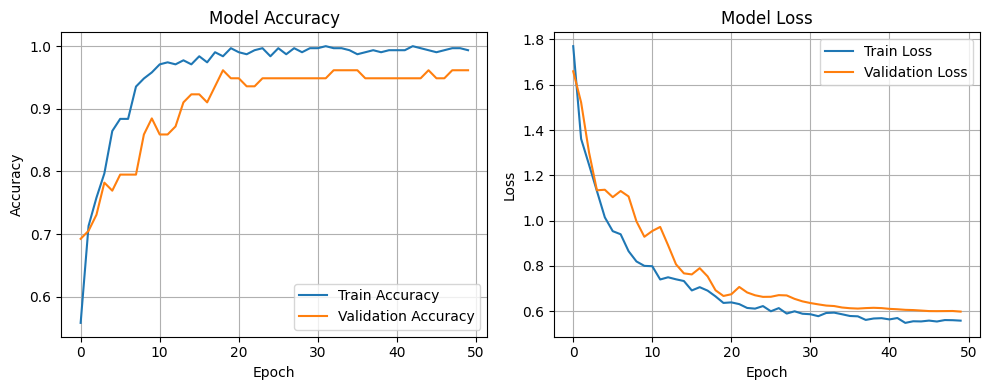

In [73]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step  


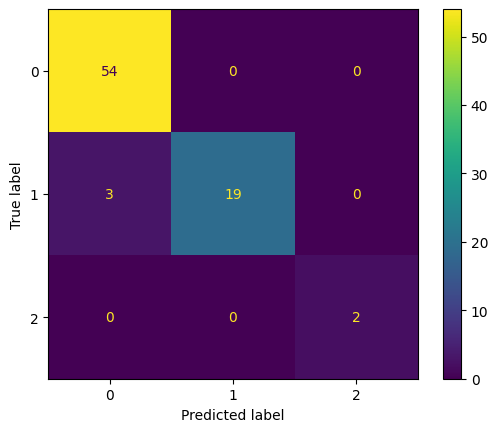

In [74]:
cnn_pred = cnn_model.predict(X_val_img).argmax(axis=1)
y_true = y_val_img.argmax(axis=1)
cm = confusion_matrix(y_true, cnn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ANN Model

In [182]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_label), y=y_train_label)
print("Class weights:", class_weights)
class_weight = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(class_weight)

Class weights: [0.45722714 1.56565657 5.74074074]
{0: 0.45722713864306785, 1: 1.5656565656565657, 2: 5.7407407407407405}


In [183]:
ann_model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation='relu'),           
    layers.Dense(64, activation='relu'),            
    layers.Dense(3, activation='softmax')          
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [184]:
optimizer = Adam(learning_rate=0.002)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ann_model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

ann_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_107 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,699 (22.26 KB)

 Trainable params: 5,699 (22.26 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
y_train = y_train_tabular.to_numpy() if hasattr(y_train_tabular, "to_numpy") else np.array(y_train_tabular)
y_test = y_test_tabular.to_numpy() if hasattr(y_test_tabular, "to_numpy") else np.array(y_test_tabular)

y_train_tabular = y_train.astype(int)
y_test_tabular = y_test.astype(int)

In [186]:
history = ann_model.fit(X_train_tabular, y_train_tabular, epochs=65, batch_size=32,validation_data=(X_test_tabular, y_test_tabular),callbacks=[early_stop],class_weight=class_weight)

test_loss, test_accuracy = ann_model.evaluate(X_test_tabular, y_test_tabular)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3564 - loss: 1.1111 - val_accuracy: 0.2564 - val_loss: 1.1117
Epoch 2/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1924 - loss: 1.0636 - val_accuracy: 0.4103 - val_loss: 1.0983
Epoch 3/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3451 - loss: 1.0450 - val_accuracy: 0.5256 - val_loss: 1.0603
Epoch 4/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5517 - loss: 1.0284 - val_accuracy: 0.5641 - val_loss: 1.0368
Epoch 5/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5827 - loss: 1.0128 - val_accuracy: 0.5769 - val_loss: 1.0166
Epoch 6/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5819 - loss: 0.9968 - val_accuracy: 0.5769 - val_loss: 0.9970
Epoch 7/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5982 - loss: 0.9795 - val_accuracy: 0.5769 - val_loss: 0.9815
Epoch 8/65
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6024 - loss: 0.9618 - val_accuracy: 0.5769 - val_lo

# Figures

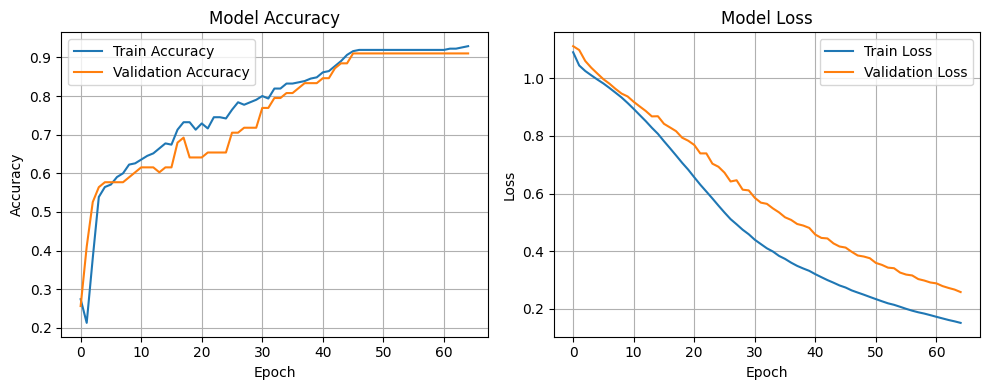

In [187]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


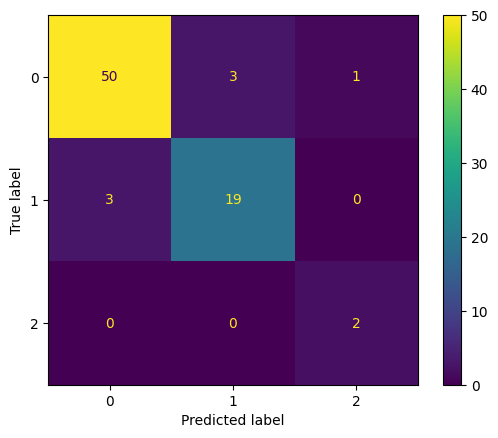

In [188]:
ann_pred = ann_model.predict(X_test_tabular).argmax(axis=1)
y_true = y_test_tabular.argmax(axis=1)
cm = confusion_matrix(y_true, ann_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Late Fusion

In [189]:
cnn_pred = cnn_model.predict(X_val_img)
ann_pred = ann_model.predict(X_test_tabular)
fused_pred = (0.6 * cnn_pred) + (0.4 * ann_pred)
final_classes = np.argmax(fused_pred, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [190]:
true_classes = np.argmax(y_test_tabular, axis=1)
accuracy = accuracy_score(true_classes, final_classes)
print(f"Fused Model Accuracy: {accuracy:.4f}")


Fused Model Accuracy: 0.9744


In [191]:
#STACKING:
#Stack predictions as new features
X_fusion = np.concatenate([cnn_pred, ann_pred], axis=1)  # shape: (n_samples, num_classes * 2)
y_true = np.argmax(y_val_img, axis=1)
#Train meta-classifier (e.g., logistic regression)
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()#max_iter=1000
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    X_fusion, y_true, test_size=0.3, random_state=42, stratify=y_true
)

meta_model.fit(X_meta_train, y_meta_train)
meta_preds = meta_model.predict(X_meta_val)

accuracy = accuracy_score(y_meta_val, meta_preds)
print(f"Meta-Model Accuracy: {accuracy:.4f}")
print(classification_report(y_meta_val, meta_preds))

Meta-Model Accuracy: 0.9583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.88      1.00      0.93         7
           2       0.00      0.00      0.00         1

    accuracy                           0.96        24
   macro avg       0.62      0.67      0.64        24
weighted avg       0.92      0.96      0.94        24



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Architecture

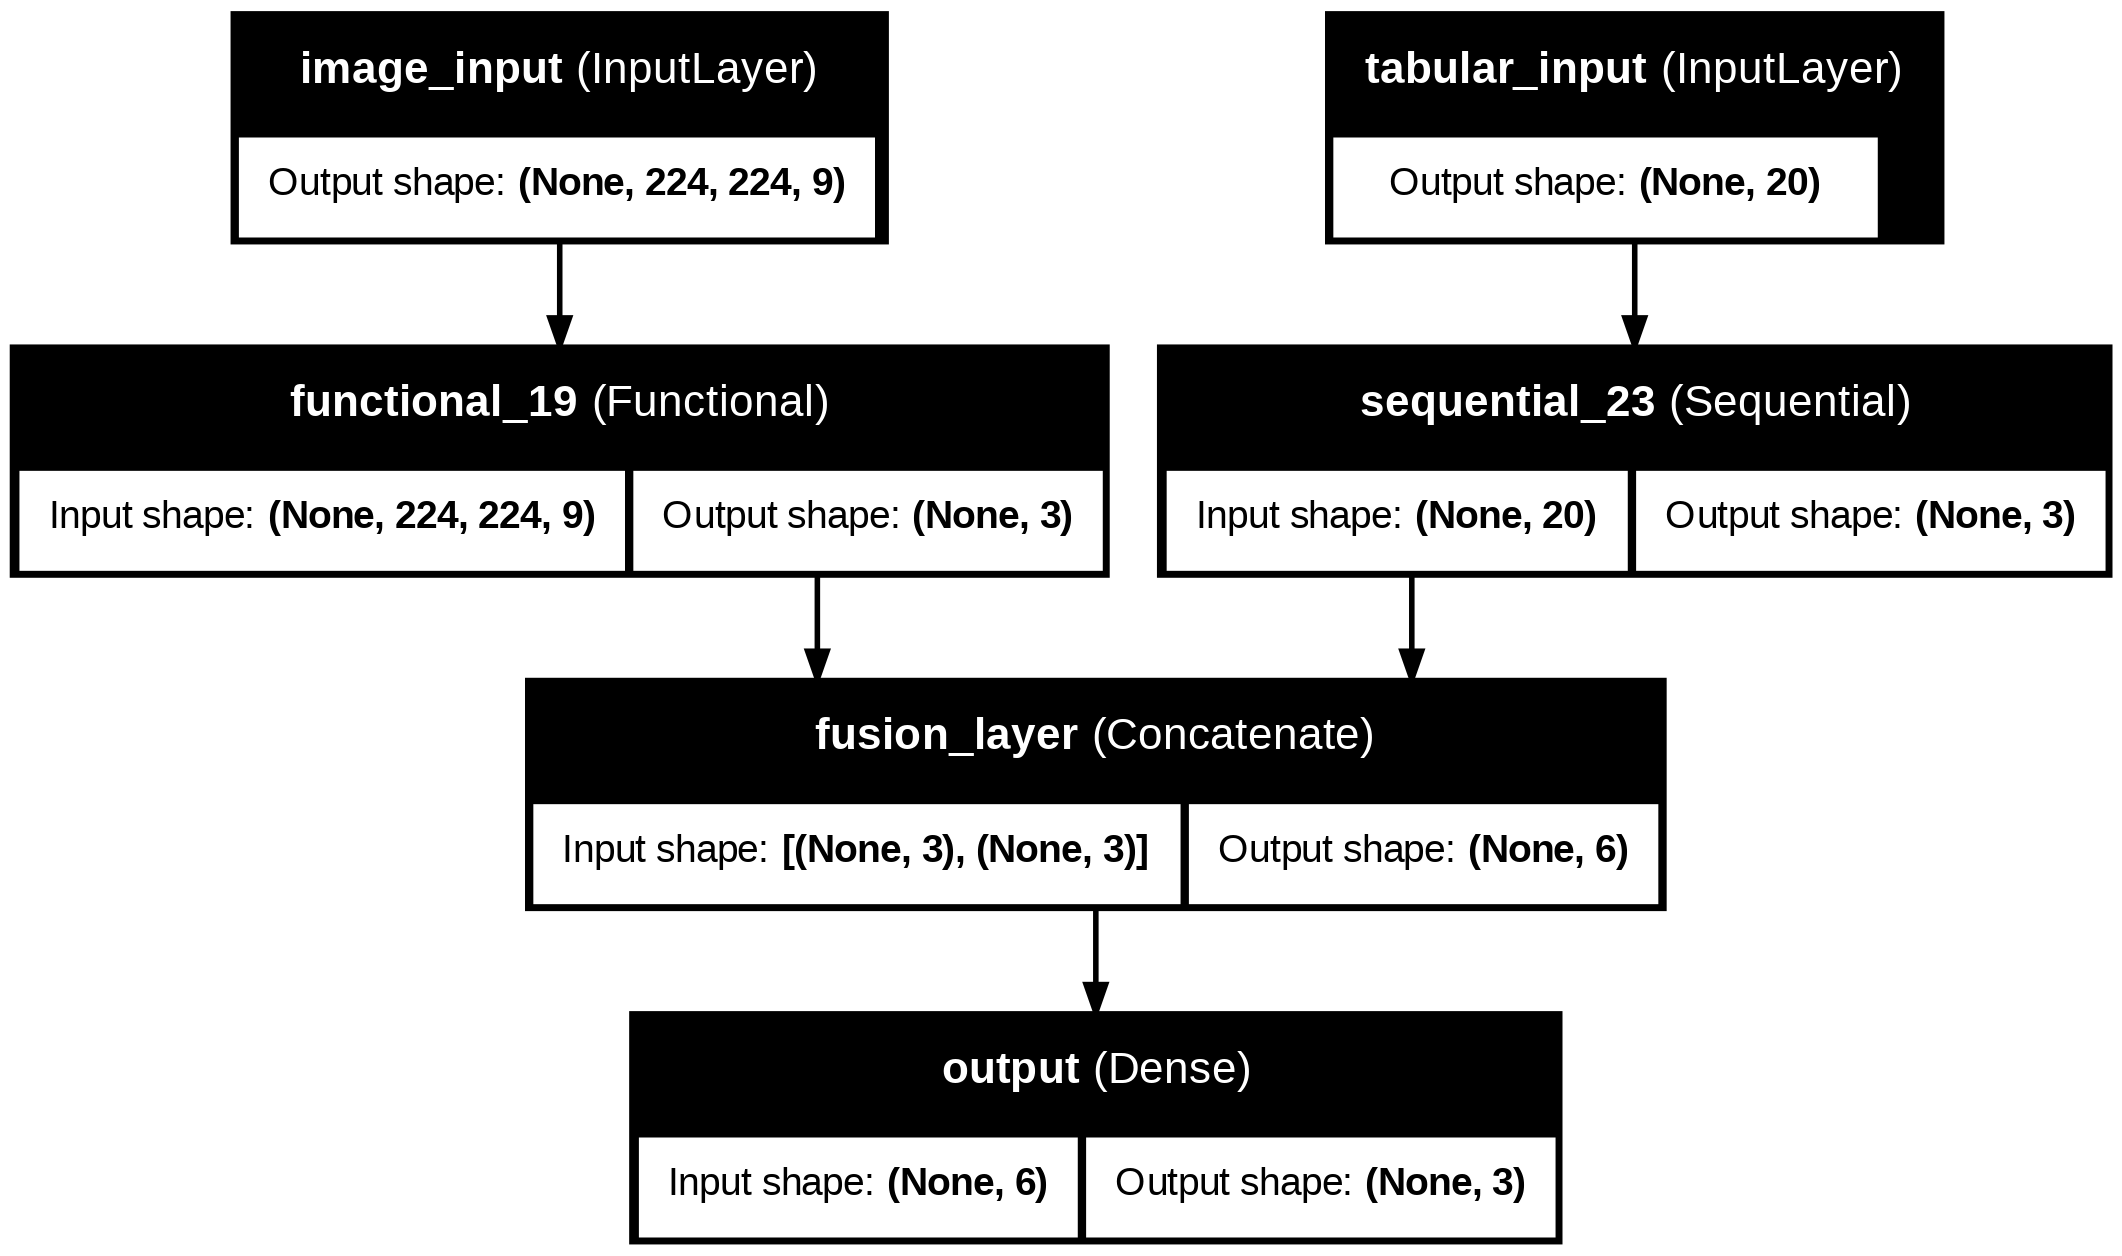

In [203]:
plot_model(
    fusion_model,
    to_file="fusion_model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="UD"
)